In [ ]:
from pymongo import MongoClient
import logging

# Configure logging
logging.basicConfig(filename='analysis_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

client = MongoClient("mongodb://localhost:27017/")
db = client.bachelor

In [ ]:
# Wie viel Prozent der Packages haben einen Security Report?
packages_with_security_report_count = db.packages.count_documents({'security_report_summary': {'$exists': True}})
packages_with_security_report_percentage = (packages_with_security_report_count / packages_count) * 100 if packages_count > 0 else 0
print(f"Packages with security report: {packages_with_security_report_percentage:.2f}%")
print(f"Packages with security report: {packages_with_security_report_count} of {packages_count}")

Packages with security report: 55.90%
Packages with security report: 7970 of 14257


In [15]:
# Top 20% der Helm Charts -> Wie viel Prozent haben einen Security Report?
packages_cursor = db.packages.find({}, {
    'package_id': 1, 
    'stats.subscriptions': 1, 
    'security_report_summary': 1
})

package_list = []
for pkg in packages_cursor:
    package_list.append({
        'package_id': pkg.get('package_id'),
        'subscriptions': pkg.get('stats', {}).get('subscriptions', 0),
        'has_security_report': 'security_report_summary' in pkg and pkg['security_report_summary'] is not None
    })

sorted_packages = sorted(package_list, key=lambda x: x['subscriptions'], reverse=True)

top_20_percent_index = int(len(sorted_packages) * 0.20)
top_20_packages = sorted_packages[:top_20_percent_index]

count_with_report_in_top_20 = sum(1 for pkg in top_20_packages if pkg['has_security_report'])

if top_20_percent_index > 0:
    percentage_with_report_in_top_20 = (count_with_report_in_top_20 / top_20_percent_index) * 100
else:
    percentage_with_report_in_top_20 = 0

print(f"Anzahl der Packages in den Top 20% (nach Subscriptions): {top_20_percent_index}")
print(f"Anzahl davon mit einem Security Report: {count_with_report_in_top_20}")
print(f"Prozentsatz der Top 20% Packages mit einem Security Report: {percentage_with_report_in_top_20:.2f}%")

Anzahl der Packages in den Top 20% (nach Subscriptions): 2851
Anzahl davon mit einem Security Report: 1811
Prozentsatz der Top 20% Packages mit einem Security Report: 63.52%


In [ ]:
# Wie viele haben keine einzige Schwachstelle?
packages_with_no_vulnerabilities_count = db.packages.count_documents({
    'security_report_summary.critical': 0,
    'security_report_summary.high': 0,
    'security_report_summary.medium': 0,
    'security_report_summary.low': 0,
    'security_report_summary.unknown': 0
})
print(f"Packages with no vulnerabilities in any category: {packages_with_no_vulnerabilities_count}")



Packages with no vulnerabilities in any category: 363


In [5]:
#Wie viele haben mindestens eine critical Schwachstelle?
packages_with_critical_vulnerability_count = db.packages.count_documents({
    'security_report_summary.critical': {'$gt': 0}
})
print(f"Packages with minimum one critical vulnerabilities: {packages_with_critical_vulnerability_count}")

Packages with minimum one critical vulnerabilities: 5714


In [6]:
# Wie viele Schwachstellen gibt es insgesamt?
total_vulnerabilities_count = db.packages.aggregate([
    {
        '$group': {
            '_id': None,
            'total': {
                '$sum': {
                    '$add': [
                        {'$ifNull': ['$security_report_summary.critical', 0]},
                        {'$ifNull': ['$security_report_summary.high', 0]},
                        {'$ifNull': ['$security_report_summary.medium', 0]},
                        {'$ifNull': ['$security_report_summary.low', 0]},
                        {'$ifNull': ['$security_report_summary.unknown', 0]}
                    ]
                }
            }
        }
    }
])
total_vulnerabilities = list(total_vulnerabilities_count)
if total_vulnerabilities:
    print(f"Total vulnerabilities across all packages: {total_vulnerabilities[0]['total']}")
else:
    print("Total vulnerabilities across all packages: 0")

Total vulnerabilities across all packages: 4401069


In [5]:
# Berechnung der Schwachstellenanzahl pro Kategorie
vulnerability_counts = db.packages.aggregate([
    {
        '$group': {
            '_id': None,
            'total_critical': {'$sum': '$security_report_summary.critical'},
            'total_high': {'$sum': '$security_report_summary.high'},
            'total_medium': {'$sum': '$security_report_summary.medium'},
            'total_low': {'$sum': '$security_report_summary.low'},
            'total_unknown': {'$sum': '$security_report_summary.unknown'}
        }
    }
])

counts = list(vulnerability_counts)
print("Counts list length: ", counts)

if counts:
    critical_count = counts[0].get('total_critical', 0)
    high_count = counts[0].get('total_high', 0)
    medium_count = counts[0].get('total_medium', 0)
    low_count = counts[0].get('total_low', 0)
    unknown_count = counts[0].get('total_unknown', 0)
else:
    critical_count = high_count = medium_count = low_count = unknown_count = 0

print(f"Total Critical Vulnerabilities: {critical_count}")
print(f"Total High Vulnerabilities: {high_count}")
print(f"Total Medium Vulnerabilities: {medium_count}")
print(f"Total Low Vulnerabilities: {low_count}")
print(f"Total Unknown Vulnerabilities: {unknown_count}")
print(f"Total Vulnerabilities: {critical_count + high_count + medium_count + low_count + unknown_count}")

Counts list length:  [{'_id': None, 'total_critical': 136604, 'total_high': 850906, 'total_medium': 2120306, 'total_low': 1263082, 'total_unknown': 30171}]
Total Critical Vulnerabilities: 136604
Total High Vulnerabilities: 850906
Total Medium Vulnerabilities: 2120306
Total Low Vulnerabilities: 1263082
Total Unknown Vulnerabilities: 30171
Total Vulnerabilities: 4401069


In [20]:
vulnerability_id_counts = {}

for report_doc in db.reports.find({}):
    for key in report_doc:
        if key == '_id':
            continue
        
        image_data = report_doc[key]
        
        if isinstance(image_data, dict) and "Results" in image_data:
            results_list = image_data.get("Results", [])
            
            if not isinstance(results_list, list):
                continue

            for result_item in results_list:
                if isinstance(result_item, dict) and "Vulnerabilities" in result_item:
                    vulnerabilities_list = result_item.get("Vulnerabilities", [])

                    if not isinstance(vulnerabilities_list, list):
                        continue
                        
                    for vulnerability in vulnerabilities_list:
                        if isinstance(vulnerability, dict):
                            vulnerability_id = vulnerability.get("VulnerabilityID")
                            if vulnerability_id:
                                if vulnerability_id in vulnerability_id_counts:
                                    vulnerability_id_counts[vulnerability_id] += 1
                                else:
                                    vulnerability_id_counts[vulnerability_id] = 1



# Top 20 häufigste Schwachstellen ausgeben
top_20_vulnerabilities = sorted(vulnerability_id_counts.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 most common vulnerabilities:")
for vuln_id, count in top_20_vulnerabilities:
    print(f"{vuln_id}: {count} occurrences")



Top 20 most common vulnerabilities:
CVE-2022-0563: 29727 occurrences
CVE-2022-29458: 12677 occurrences
CVE-2023-4039: 12595 occurrences
CVE-2018-5709: 12588 occurrences
CVE-2023-50495: 12199 occurrences
CVE-2021-37600: 12011 occurrences
CVE-2022-3219: 11746 occurrences
CVE-2024-22365: 10651 occurrences
CVE-2019-1010022: 9957 occurrences
CVE-2010-4756: 9931 occurrences
CVE-2018-20796: 9931 occurrences
CVE-2019-1010023: 9931 occurrences
CVE-2019-1010024: 9931 occurrences
CVE-2019-1010025: 9931 occurrences
CVE-2019-9192: 9931 occurrences
CVE-2024-28085: 9793 occurrences
CVE-2024-26458: 9601 occurrences
CVE-2024-26461: 9601 occurrences
CVE-2022-27943: 9562 occurrences
CVE-2022-1304: 9547 occurrences


Anzahl an Helm Charts: 7970
Durchschnittliche Anzahl an Schwachstellen pro Helm Chart: 552.20
Median Anzahl an Schwachstellen pro Helm Chart: 134.00
Standardabweichung Anzahl an Schwachstellen pro Helm Chart: 1333.87


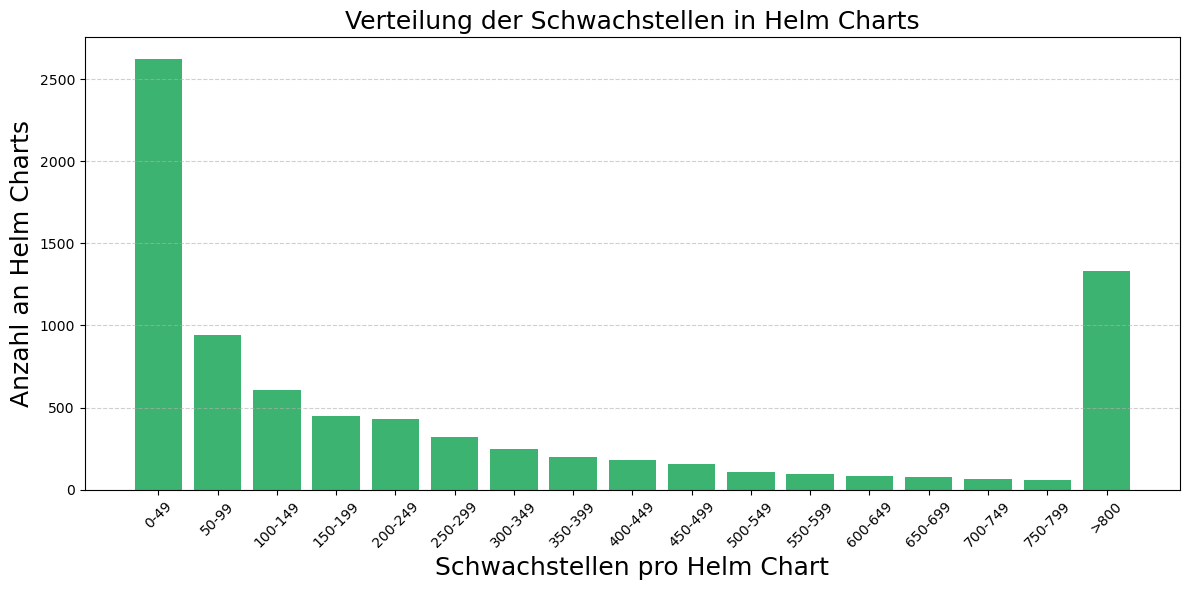

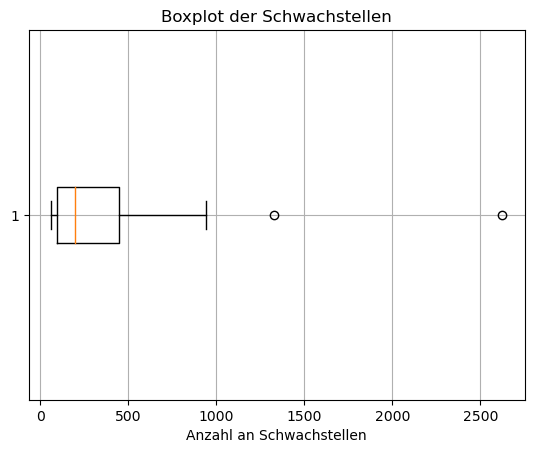

In [2]:
# Durchschnitt und Median pro Helm Chart + Verteilung
from statistics import median, mean, stdev

chart_list = {}

for package in db.packages.find():
    if "security_report_summary" in package and package['security_report_summary']:
        total_vulnerabilities = 0
        for severity in package['security_report_summary'].values():
            total_vulnerabilities += severity
        
        chart_list[package['package_id']] = total_vulnerabilities

chart_values = list(chart_list.values())

chart_mean = mean(chart_values) if chart_values else 0
chart_median = median(chart_values) if chart_values else 0
chart_stdev = stdev(chart_values) if chart_values else 0

print(f"Anzahl an Helm Charts: {len(chart_list)}")
print(f"Durchschnittliche Anzahl an Schwachstellen pro Helm Chart: {chart_mean:.2f}")
print(f"Median Anzahl an Schwachstellen pro Helm Chart: {chart_median:.2f}")
print(f"Standardabweichung Anzahl an Schwachstellen pro Helm Chart: {chart_stdev:.2f}")

import matplotlib.pyplot as plt
from collections import defaultdict

groups = defaultdict(int)

for chart, count in chart_list.items():
    if count >= 800:
        label = ">800"
    else:
        start = (count // 50) * 50
        end = start + 49
        label = f"{start}-{end}"
    groups[label] += 1

def sort_key(label):
    if label == ">800":
        return 10000
    return int(label.split("-")[0])

labels = sorted(groups.keys(), key=sort_key)
values = [groups[label] for label in labels]

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color="mediumseagreen")
plt.xlabel("Schwachstellen pro Helm Chart", fontsize=18)
plt.ylabel("Anzahl an Helm Charts", fontsize=18)
plt.title("Verteilung der Schwachstellen in Helm Charts", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

plt.boxplot(values, vert=False, showfliers=True)
plt.title("Boxplot der Schwachstellen")
plt.xlabel("Anzahl an Schwachstellen")
plt.grid(True)
plt.show()

In [2]:
# Wie viele Images gibt es insgesamt?

image_counter = 0
images = []

for report_doc in db.reports.find({}):
    for key in report_doc.keys():
        if key == '_id':
            continue
        image_counter += 1
        images.append(key)

print(f"Total number of images: {image_counter}")
print(f"Total number of unique images: {len(images)}")        


Total number of images: 13212
Total number of unique images: 13212


In [10]:
# Wie viel Prozent der Helm Charts betrifft eine bestimmte Schwachstelle?

def count_helm_charts_with_vulnerability(vulnerability_id):
    helm_chart_counter = 0
    for report in db.reports.find({}):
        helm_chart_counter += find_vulnerability_in_report(vulnerability_id, report)
    return helm_chart_counter

def find_vulnerability_in_report(vulnerability_id,report_doc):
    for report in report_doc:
        if report == '_id':
            continue
        if "Results" in report_doc[report]:
                for image in report_doc[report]["Results"]:
                    if "Vulnerabilities" in image:
                        for vulnerability in image["Vulnerabilities"]:
                            if "VulnerabilityID" in vulnerability and vulnerability["VulnerabilityID"] == vulnerability_id:
                                return 1
    return 0

vulnerability_id_1 = "CVE-2022-0563"
vulnerability_id_2 = "CVE-2022-29458"
vulnerability_id_3 = "CVE-2023-4039"
vulnerability_id_4 = "CVE-2018-5709"
vulnerability_id_5 = "CVE-2023-50495"
vulnerability_id_6 = "CVE-2021-37600"
vulnerability_id_7 = "CVE-2022-3219"
vulnerability_id_8 = "CVE-2024-22365"
vulnerability_id_9 = "CVE-2019-1010022"
vulnerability_id_10 = "CVE-2010-4756"



helm_charts_with_vulnerability_1 = count_helm_charts_with_vulnerability(vulnerability_id_1)
helm_charts_with_vulnerability_2 = count_helm_charts_with_vulnerability(vulnerability_id_2)
helm_charts_with_vulnerability_3 = count_helm_charts_with_vulnerability(vulnerability_id_3)
helm_charts_with_vulnerability_4 = count_helm_charts_with_vulnerability(vulnerability_id_4)
helm_charts_with_vulnerability_5 = count_helm_charts_with_vulnerability(vulnerability_id_5)
helm_charts_with_vulnerability_6 = count_helm_charts_with_vulnerability(vulnerability_id_6)
helm_charts_with_vulnerability_7 = count_helm_charts_with_vulnerability(vulnerability_id_7)
helm_charts_with_vulnerability_8 = count_helm_charts_with_vulnerability(vulnerability_id_8)
helm_charts_with_vulnerability_9 = count_helm_charts_with_vulnerability(vulnerability_id_9)
helm_charts_with_vulnerability_10 = count_helm_charts_with_vulnerability(vulnerability_id_10)


print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_1}: {helm_charts_with_vulnerability_1}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_2}: {helm_charts_with_vulnerability_2}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_3}: {helm_charts_with_vulnerability_3}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_4}: {helm_charts_with_vulnerability_4}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_5}: {helm_charts_with_vulnerability_5}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_6}: {helm_charts_with_vulnerability_6}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_7}: {helm_charts_with_vulnerability_7}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_8}: {helm_charts_with_vulnerability_8}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_9}: {helm_charts_with_vulnerability_9}")
print(f"Anzahl der Helm Charts mit der Schwachstelle {vulnerability_id_10}: {helm_charts_with_vulnerability_10}")

Anzahl der Helm Charts mit der Schwachstelle CVE-2022-0563: 2621
Anzahl der Helm Charts mit der Schwachstelle CVE-2022-29458: 2163
Anzahl der Helm Charts mit der Schwachstelle CVE-2023-4039: 1948
Anzahl der Helm Charts mit der Schwachstelle CVE-2018-5709: 2024
Anzahl der Helm Charts mit der Schwachstelle CVE-2023-50495: 2161
Anzahl der Helm Charts mit der Schwachstelle CVE-2021-37600: 1103
Anzahl der Helm Charts mit der Schwachstelle CVE-2022-3219: 3006
Anzahl der Helm Charts mit der Schwachstelle CVE-2024-22365: 1855
Anzahl der Helm Charts mit der Schwachstelle CVE-2019-1010022: 2638
Anzahl der Helm Charts mit der Schwachstelle CVE-2010-4756: 2632
